In [1]:
# Numpy for maths
import numpy as np
from numpy import linalg as LA
from numpy.linalg import eig

# Matplotlib for plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm

# Scipy to solve linear systems
from scipy.linalg import solve

# Networkx for graphs
import networkx as nx
# Pandas for dataframes
import pandas as pd

# Plotting defaults
plt.rcParams['figure.dpi'] = 1050

### Initialization

In [2]:
edges = pd.read_csv('london_tube_edges.txt', sep=" ")
nodes = pd.read_csv('london_tube_nodes.txt', sep=" ")
usage = pd.read_csv('london_tube_usage.txt', sep=" ")

In [3]:
def initialization(nodes, edges):
    '''
    Initialization and setup for analysis on the London tube
    network. 
    Inputs:
    - nodes: pd.DataFrame containing information on the nodes.
    - edges: pd.DataFrame contianing information on the edges.
    Outputs:
    - N: dimenion of the network.
    - G: Networkx graph of the network.
    - A: adjacency matrix.
    - D: degree matrix.
    - pos: dictionary of the postions of the stations.
    - num_edges: the number of edges in the network.
    '''
    
    N = len(nodes)

    # Create graph and matrix A
    G = nx.from_pandas_edgelist(edges, 'NodeID1', 'NodeID2')
    nodelist = list(nodes['index'])
    A = nx.to_numpy_array(G, nodelist=nodelist)
    # Create postion dictionary
    coor = nodes[['xcoor', 'ycoor']]
    pos = coor.to_dict(orient='index')

    for i in pos.keys():
        pos[i] = tuple(pos[i].values())
    
    # Create matrix D
    D = np.eye(N)
    for i in range(N):
        A_sq = A @ A
        D[i, i] = A_sq[i, i]

    num_edges = len(edges)
    
    return N, G, A, D, pos, num_edges

def spec_rad(A):
    '''
    Calculates the spectral radius of adjacency matrix A.
    Input:
    - A: adjacency matrix.
    Output:
    - spectral radius of matrix A.
    '''
    eigs = eig(A)[0]
    return max(abs(eigs))

def Katz(alpha, A, L=None, normed=False, approx=False):
    '''
    Calculates Katz centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of Katz centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether the approximation parameters
    for the modified ring are requested, default: False.
    Outputs:
    - centrality: Katz centrality.
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    Aa = np.eye(N) - alpha*A
    rhs = np.ones(N)
    centrality = solve(Aa, rhs)
    if normed == True:
        centrality /= LA.norm(centrality, 1) 
    
    if approx==True:
     
        # Roots
        t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
        t2 = (1 + np.sqrt(1 - 4*alpha**2)) / (2*alpha)
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[1 - 2*alpha*t1 - alpha*t1**(L-1), 1 - 2*alpha*t2 - alpha*t2**(L-1)],
                     [t1**(N/2-1) * (t1-2*alpha), t2**(N/2-1) * (t2-2*alpha)]])
        right = np.array([alpha / (1 - 2*alpha), 0])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return centrality, t1, t2, h1, h2
    else:
        return centrality

def NBTW_spec_rad(A, D, S):
    '''
    Calculates the spectral radius of the companion linearization
    of the reversal matrix polynomial of matrix polynomial 
    M(t) = I - At + (D-I)t^2 + (A-S)t^3. Named: C.
    Note: when dealing with an undirected network, S can be 
    replaced by A.
    Input:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    Output:
    - spectral radius of matrix C.
    '''
    N = len(A)
    # Create matrix C
    C = np.zeros((3*N, 3*N))
    C[0: N, 0: N] = A
    C[0: N, N: 2*N] = np.eye(N) - D
    C[0: N, 2*N: 3*N] = S - A
    C[N: 2*N, 0: N] = np.eye(N)
    C[2*N: 3*N, N: 2*N] = np.eye(N)
    
    eigs = eig(C)[0]
    return max(abs(eigs))

def NBTW(alpha, A, D, S, L=None, normed=False, approx=False):
    '''
    Calculates NBTW centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of NBTW centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Note: when dealing with an undirected network, S can be 
    replaced by A.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - D: diagonal degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether or not the approximation 
    parameters for the modified ring are requested, default: False.
    Outputs:
    - NBTWcentrality: NBTW centrality
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    
    # deformed graph Laplacian:
    M = np.eye(N) - A*alpha + (D-np.eye(N))*alpha**2  + (A-S)*alpha**3 
    
    rhs = (1-alpha**2) * np.ones(N)
    NBTWcentrality = solve(M, rhs)
    if normed == True:
        NBTWcentrality /= LA.norm(NBTWcentrality, 1) 
    
    if approx==True:
        # Roots
        t1 = alpha
        t2 = 1 / alpha
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[-alpha**2 + 1 + (alpha**2-1)*alpha**L, -1 + alpha**2 + (alpha**2-1)*alpha**(2-L)], 
                     [(alpha**2 - 1) * alpha**(N/2), -2*alpha**(2 - N/2) + (1 + alpha**2)*alpha**(-N/2)]])
        right = np.array([[alpha * (alpha+1)**2], [0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return NBTWcentrality, t1, t2, h1, h2
    else:
        return NBTWcentrality

def create_graph(A, nodesize, node_color, pos=None, circular=True, with_labels=True, arrows=True):
    '''
    Plots the graph associated with adjacency matrix A. 
    Inputs:
    - A: adjacency matrix
    - nodesize: list indicating the sizes of the nodes,
    typically the centrality vector.
    - node_color: list indicating the color for each node,
    typically the centrality vector.
    - pos: dictionary containing the positions of the 
    nodes. Only necessary when not dealing with a circular
    graph.
    - circular: boolean indicating whether or not a circular
    graph is required, default: True
    - with_labels: boolean indicating whether or not labels
    should be included with the nodes, default: True
    - arrows: boolean indicating whether the edges should 
    include arrows or not, default: True
    '''
    N = A.shape[0]
    
    G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
    labeldict = {}
    for i in range(N):
        labeldict[i] = i+1
        
    nodelist = [i for i in range(N)]
        
    if circular == True:
        nx.draw_circular(G, 
                         labels=labeldict, 
                         node_size=nodesize, 
                         node_color=node_color,
                         font_color='white',
                         nodelist=nodelist,
                         with_labels=with_labels,
                         arrows=arrows)
    else:
        nx.draw(G, 
                labels=labeldict, 
                node_size=nodesize, 
                node_color=node_color,
                font_color='white',
                pos=pos,
                nodelist=nodelist,
                with_labels=with_labels,
                arrows=arrows)   
    

In [4]:
N, G, A, D, pos, num_edges = initialization(nodes, edges)

### Circle line setup

In [5]:
def circle_line(nodes, edges, pos):
    '''
    Setup for analysis on the London tube network circle line,
    this function needs to be called after the initialization()
    function.
    Creates a graph only containing the circle line without the
    Hammersmith & City line appendix of this line.
    Inputs:
    - nodes: pd.DataFrame containing information on the nodes.
    - edges: pd.DataFrame contianing information on the edges.
    - pos: dictionary containing the positions of all stations
    in London.
    Outputs:
    - Gc: networkx graph of the circle line.
    - pos_circle: position dictionary of the circle line stations.
    - circle_names: list with the names of the stations.
    - circle_nodes: list with the node indices of the stations.
    '''
    # Create a dictionary containing only the cirle line edges
    layer_df = edges[['LayerID', 'NodeID1', 'NodeID2']]
    circle_df = layer_df[layer_df.LayerID == 3]
    
    # Create graph
    Gc = nx.from_pandas_edgelist(circle_df, 'NodeID1', 'NodeID2', create_using=nx.MultiDiGraph)
    
    # adding the missing reciprocal edges
    add_reciprocal = list(zip(circle_df['NodeID2'], circle_df['NodeID1']))
    Gc.add_edges_from(add_reciprocal)

    # Update the position dictionary to the circle line 
    delete = [] 
    for key, val in pos.items(): 
        if key not in list(circle_df['NodeID1']) and key not in list(circle_df['NodeID2']): 
            delete.append(key) 

    pos_circle = pos.copy()
    for i in delete: 
        del pos_circle[i] 
    
    # remove circle line appendix Hammersmith & city and 2 double nodes   
    circle_appendix = [49, 314, 276, 274, 275, 280, 204, 202, 203, 313]
    Gc.remove_nodes_from(circle_appendix) 
    # Add missing reciprocal edges around appendix
    Gc.add_edge(47, 315)
    Gc.add_edge(315, 29)
    Gc.add_edge(315, 47)
    Gc.add_edge(29, 315)
    
    circle_nodes = sorted(list(Gc.nodes()))
    circle_names = nodes.iloc[circle_nodes, 1]
    

    return Gc, pos_circle, circle_names, circle_nodes

In [6]:
Gc, pos_circle, circle_names, circle_nodes = circle_line(nodes, edges, pos)
percentage = 0.7

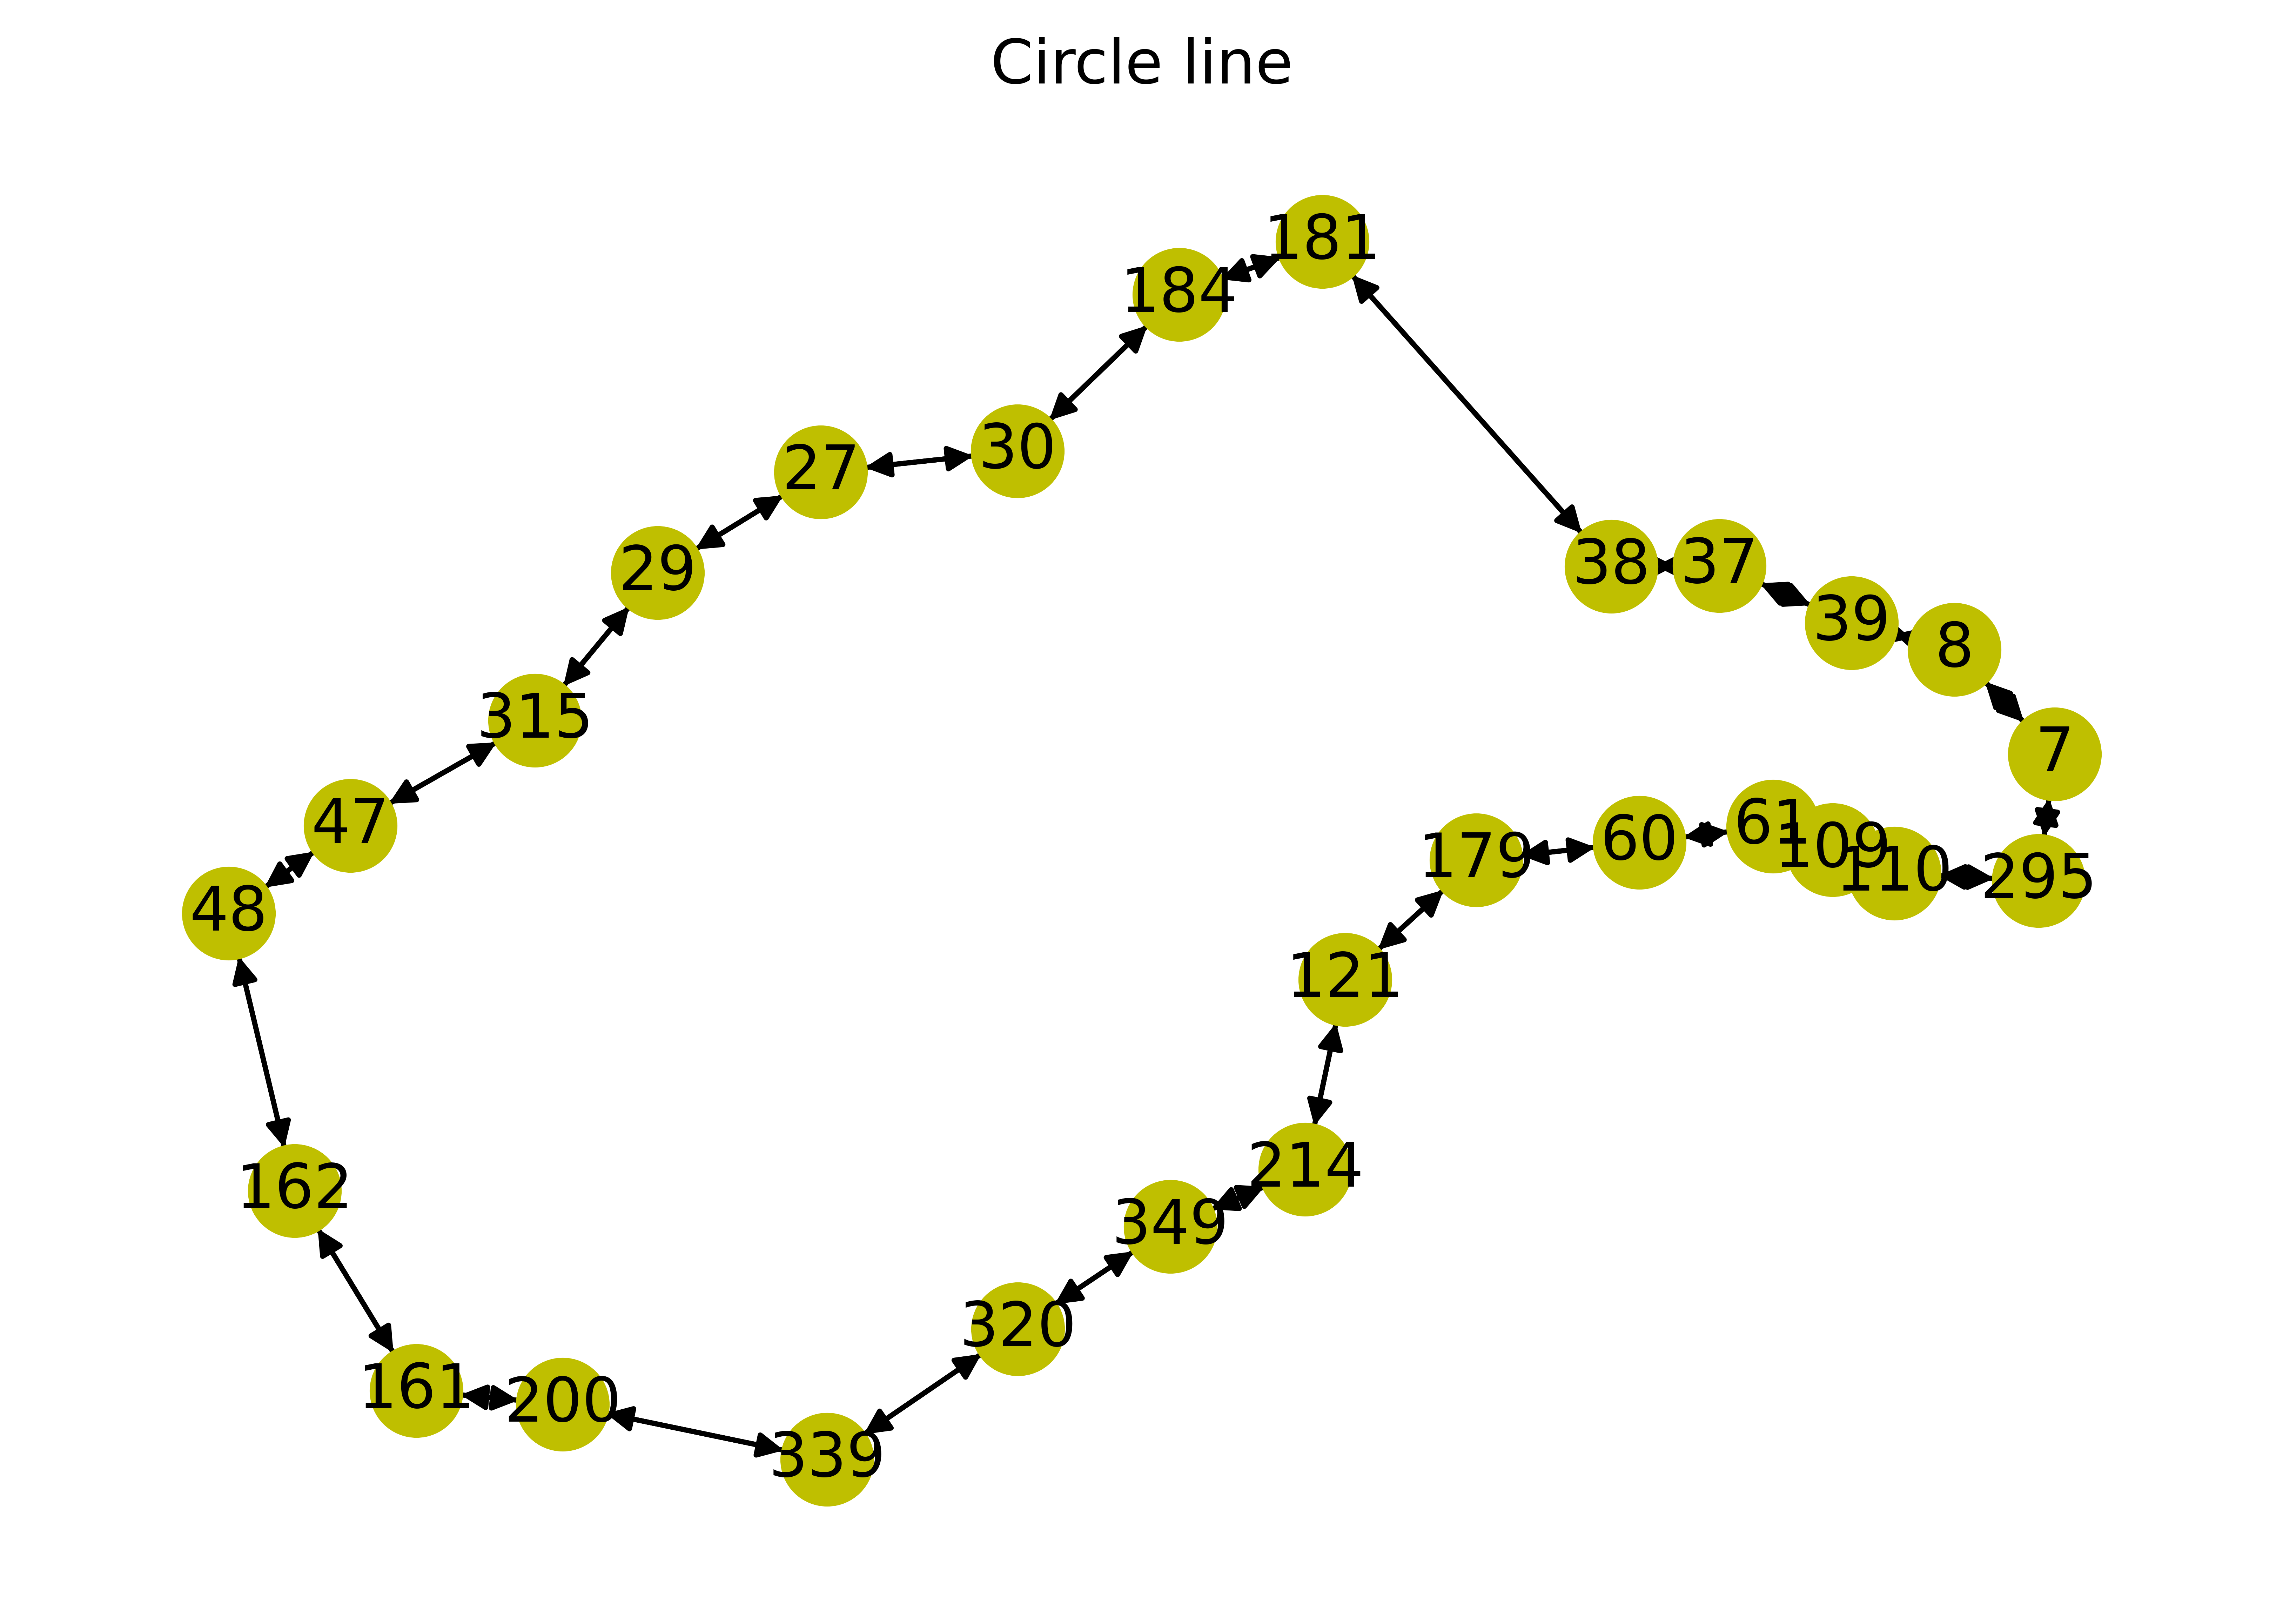

In [7]:
nx.draw(Gc, with_labels=True, pos=pos_circle, node_color='y')
plt.title('Circle line')
plt.show()

27 nodes in the circle line


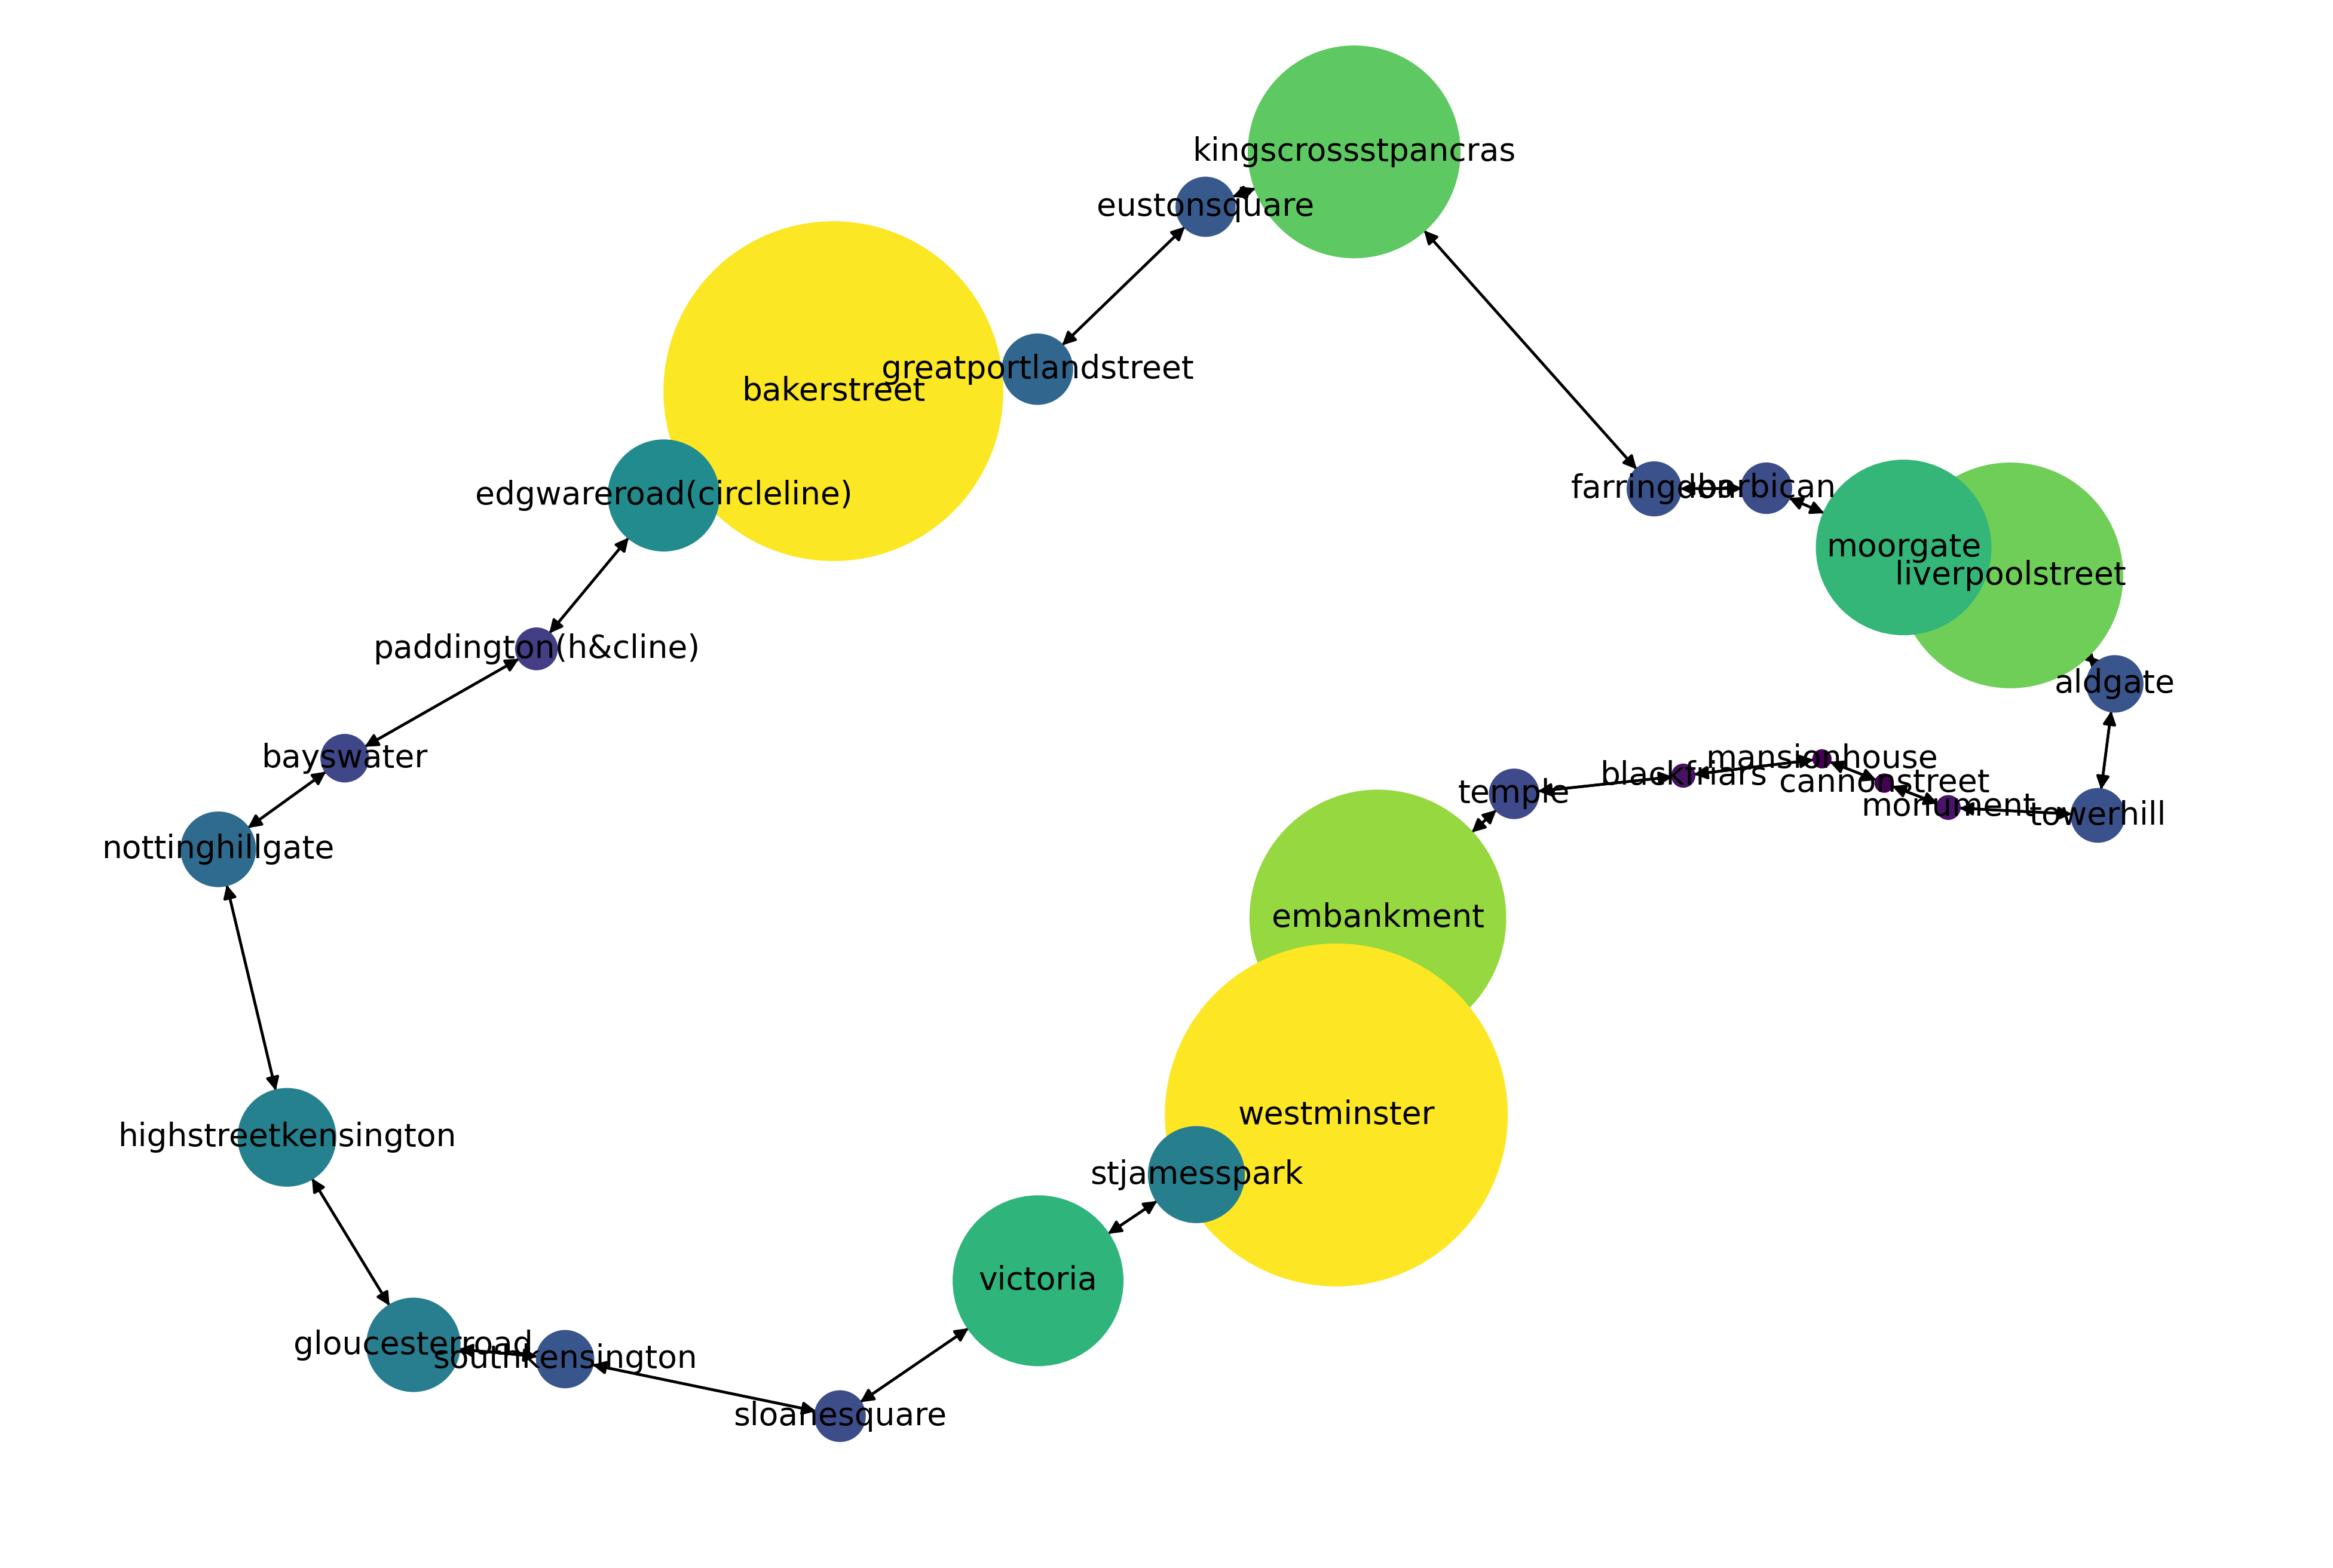

In [8]:
print(len(circle_nodes), 'nodes in the circle line')

# NBTW
a = percentage / NBTW_spec_rad(A, D, A)
NBTWC = NBTW(a, A, D, A, normed=True)
circle_NBTW = NBTWC[circle_nodes]
# Katz
t = percentage / spec_rad(A)
KatzC = Katz(t, A, normed=True)
circle_Katz = KatzC[circle_nodes]


plt.figure(figsize=(12,8), dpi=320)
nx.draw(Gc, 
        pos=pos_circle, 
        node_color=circle_NBTW, 
        node_size=(circle_NBTW*1000)**5, 
        with_labels=True, 
        nodelist=circle_nodes,
        labels=circle_names)
# plt.title('Circle line NBTW centrality with {} percent of the spectrum'.format(percentage*100))
# plt.savefig('circleNBTW{}.pdf'.format(percentage))
plt.show()

shortcut beginning: 320
shortcut end: 181


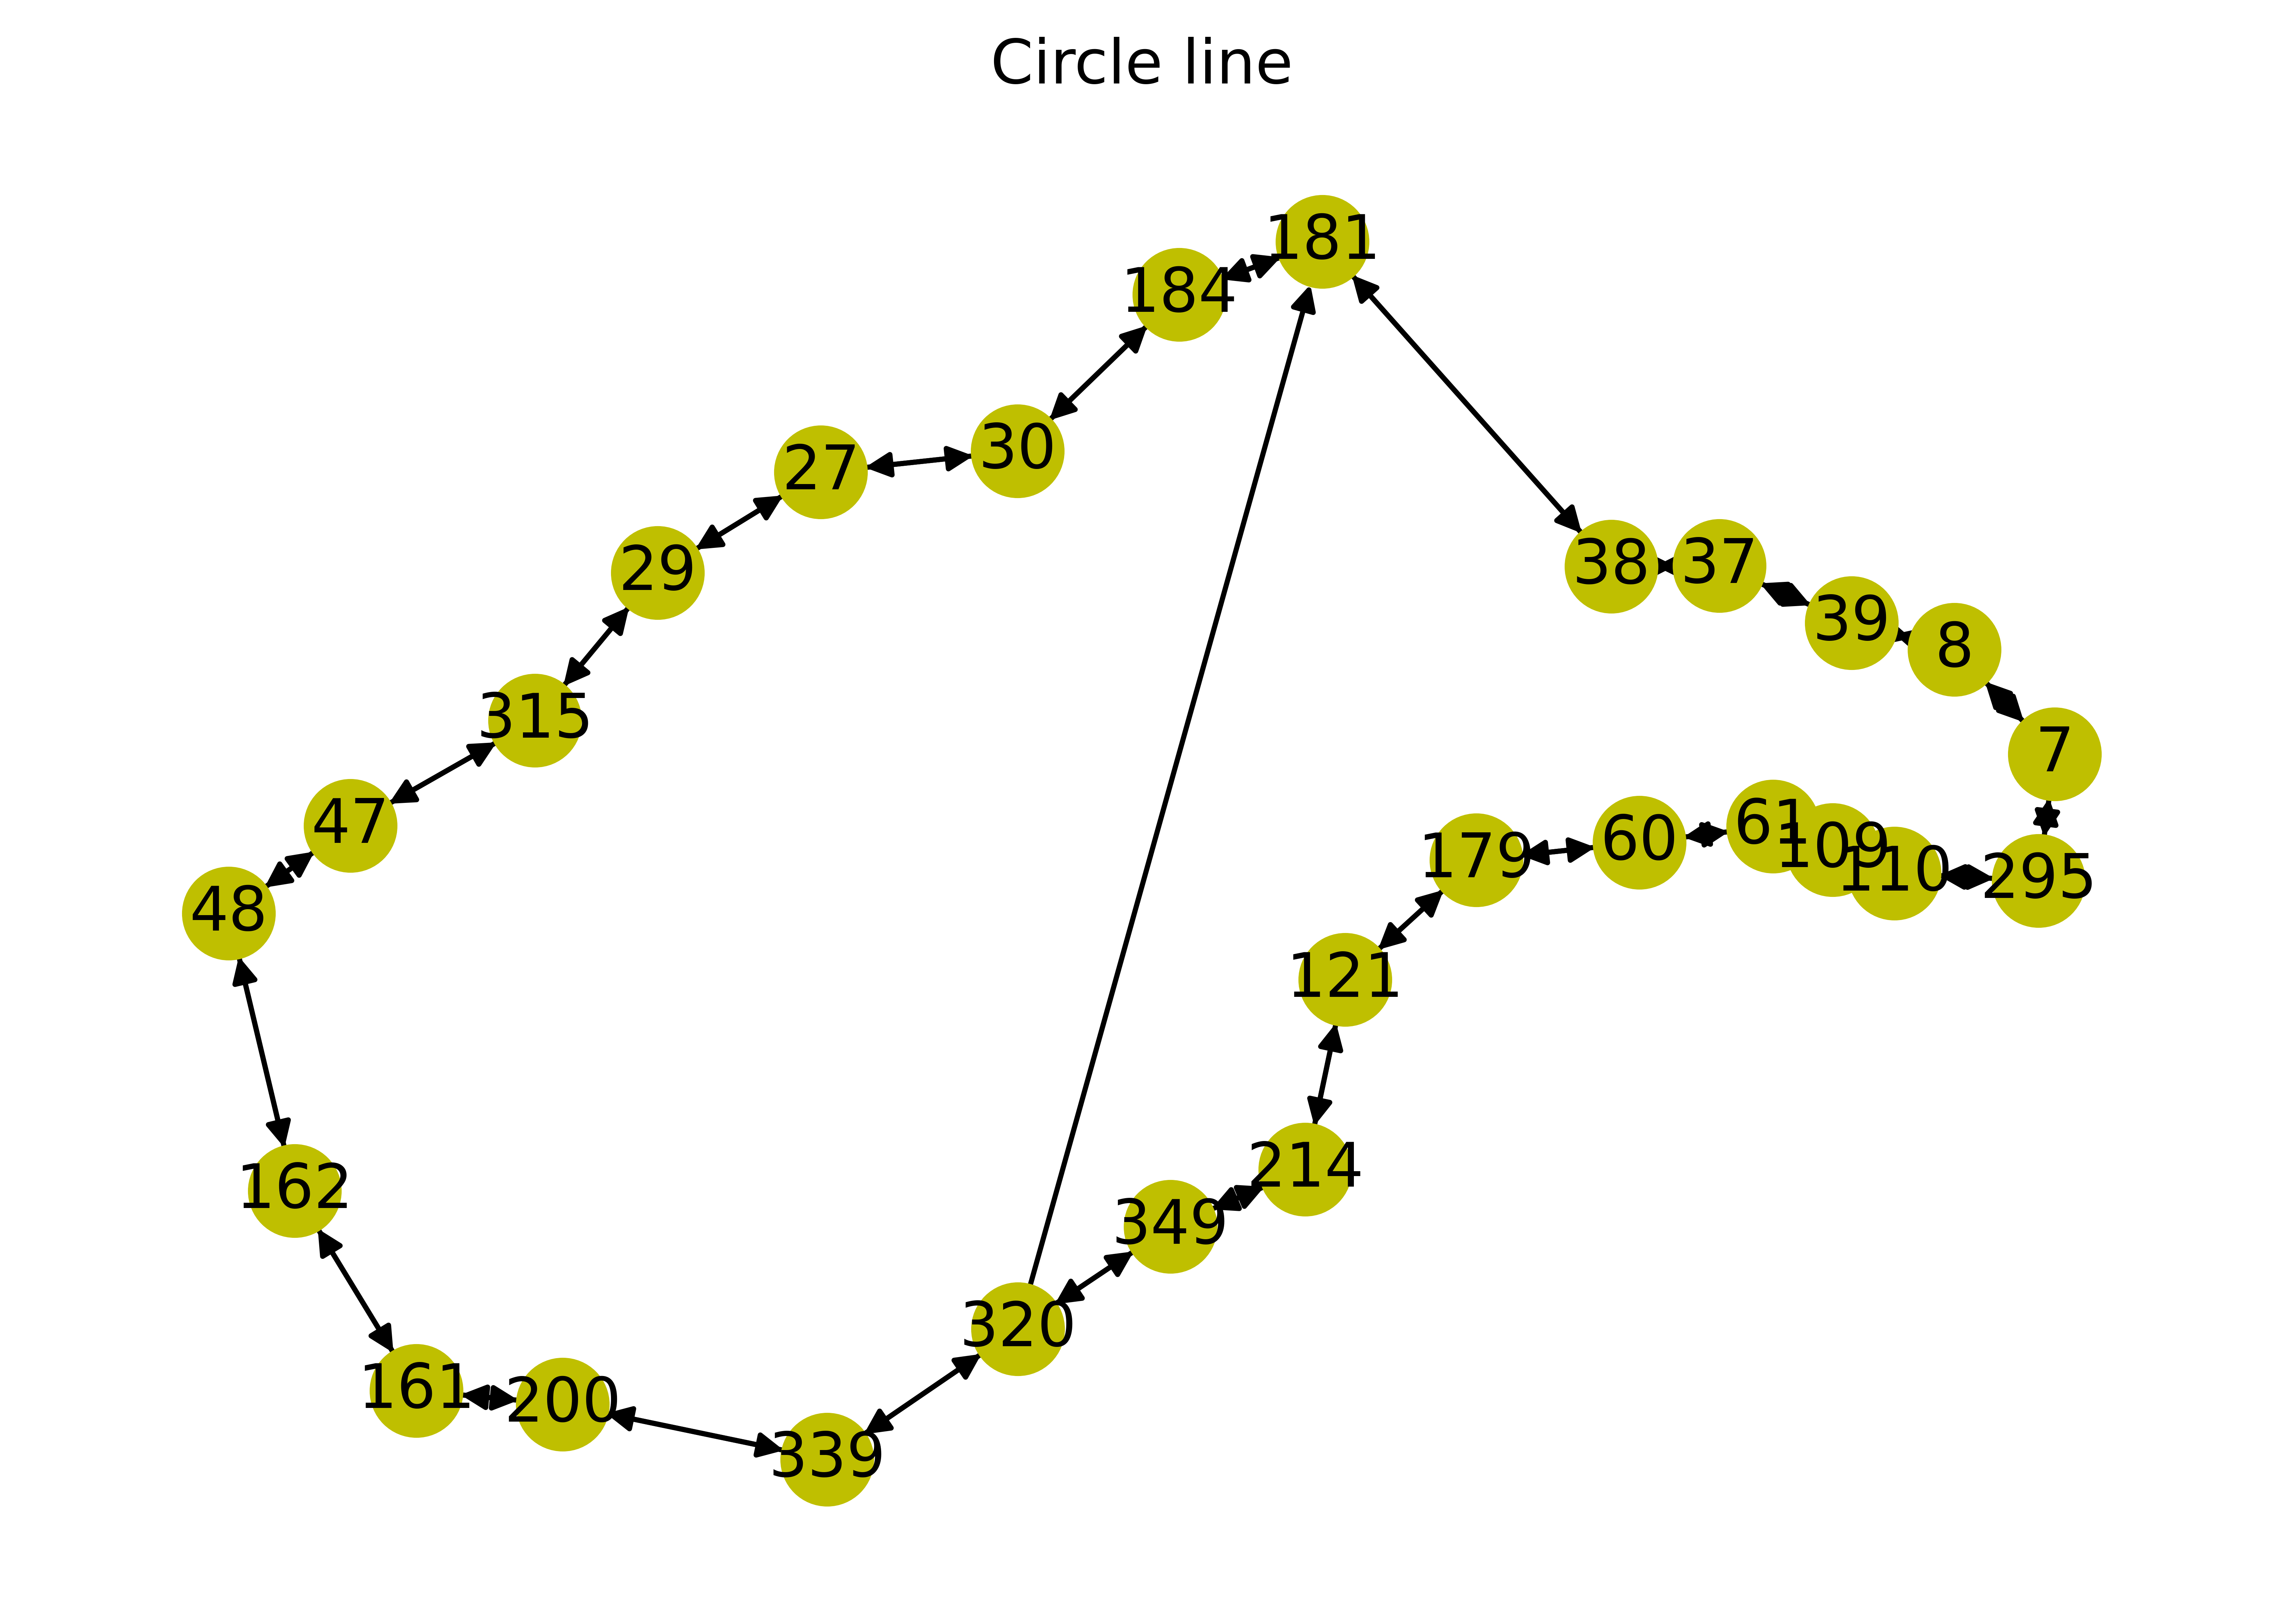

In [9]:
import random

random.seed(1235)
    
start = random.choice(circle_nodes)
start = 320
print('shortcut beginning:', start)

circle_nodes_temp = circle_nodes.copy()
circle_nodes_temp.pop(circle_nodes.index(start)-1)
circle_nodes_temp.pop(circle_nodes.index(start)+1)
circle_nodes_temp.remove(start)
finish = random.choice(circle_nodes_temp)
finish = 181
print('shortcut end:', finish)
Gs = Gc.copy()
Gs.add_edge(start, finish) # add the random edge

nx.draw(Gs, with_labels=True, pos=pos_circle, node_color='y', nodelist=circle_nodes)
plt.title('Circle line')
plt.show()

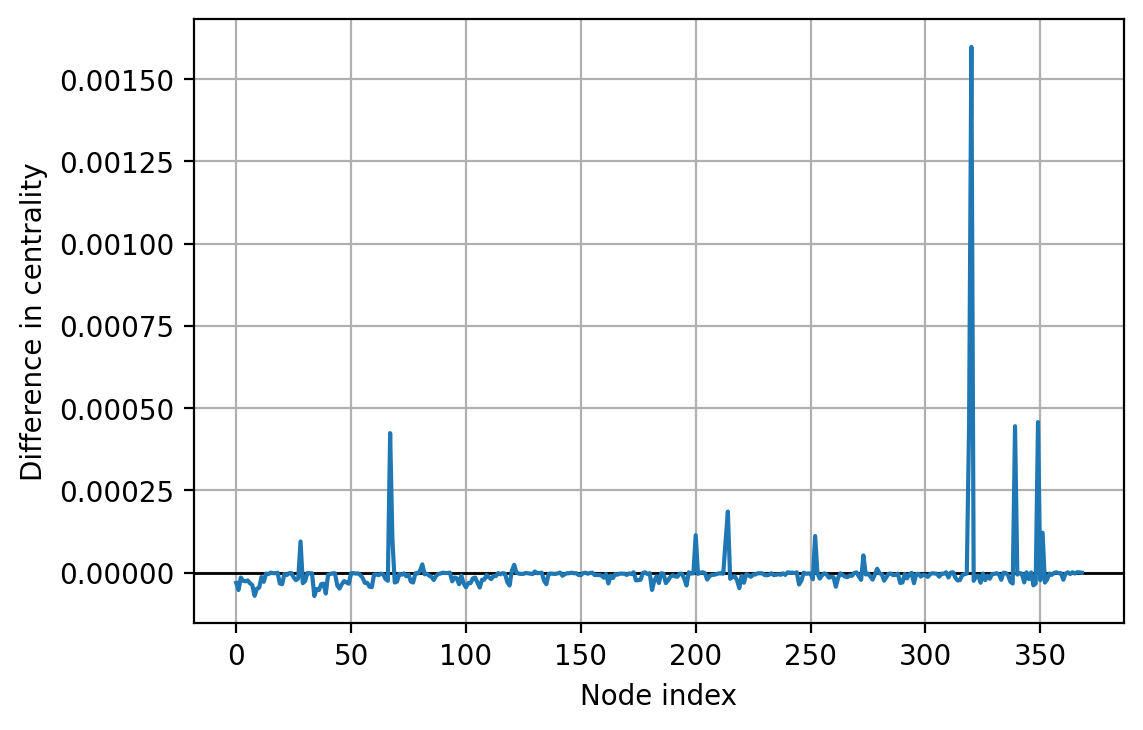

nodes in the network that significantly change centrality:
67
214
319
320
339
349


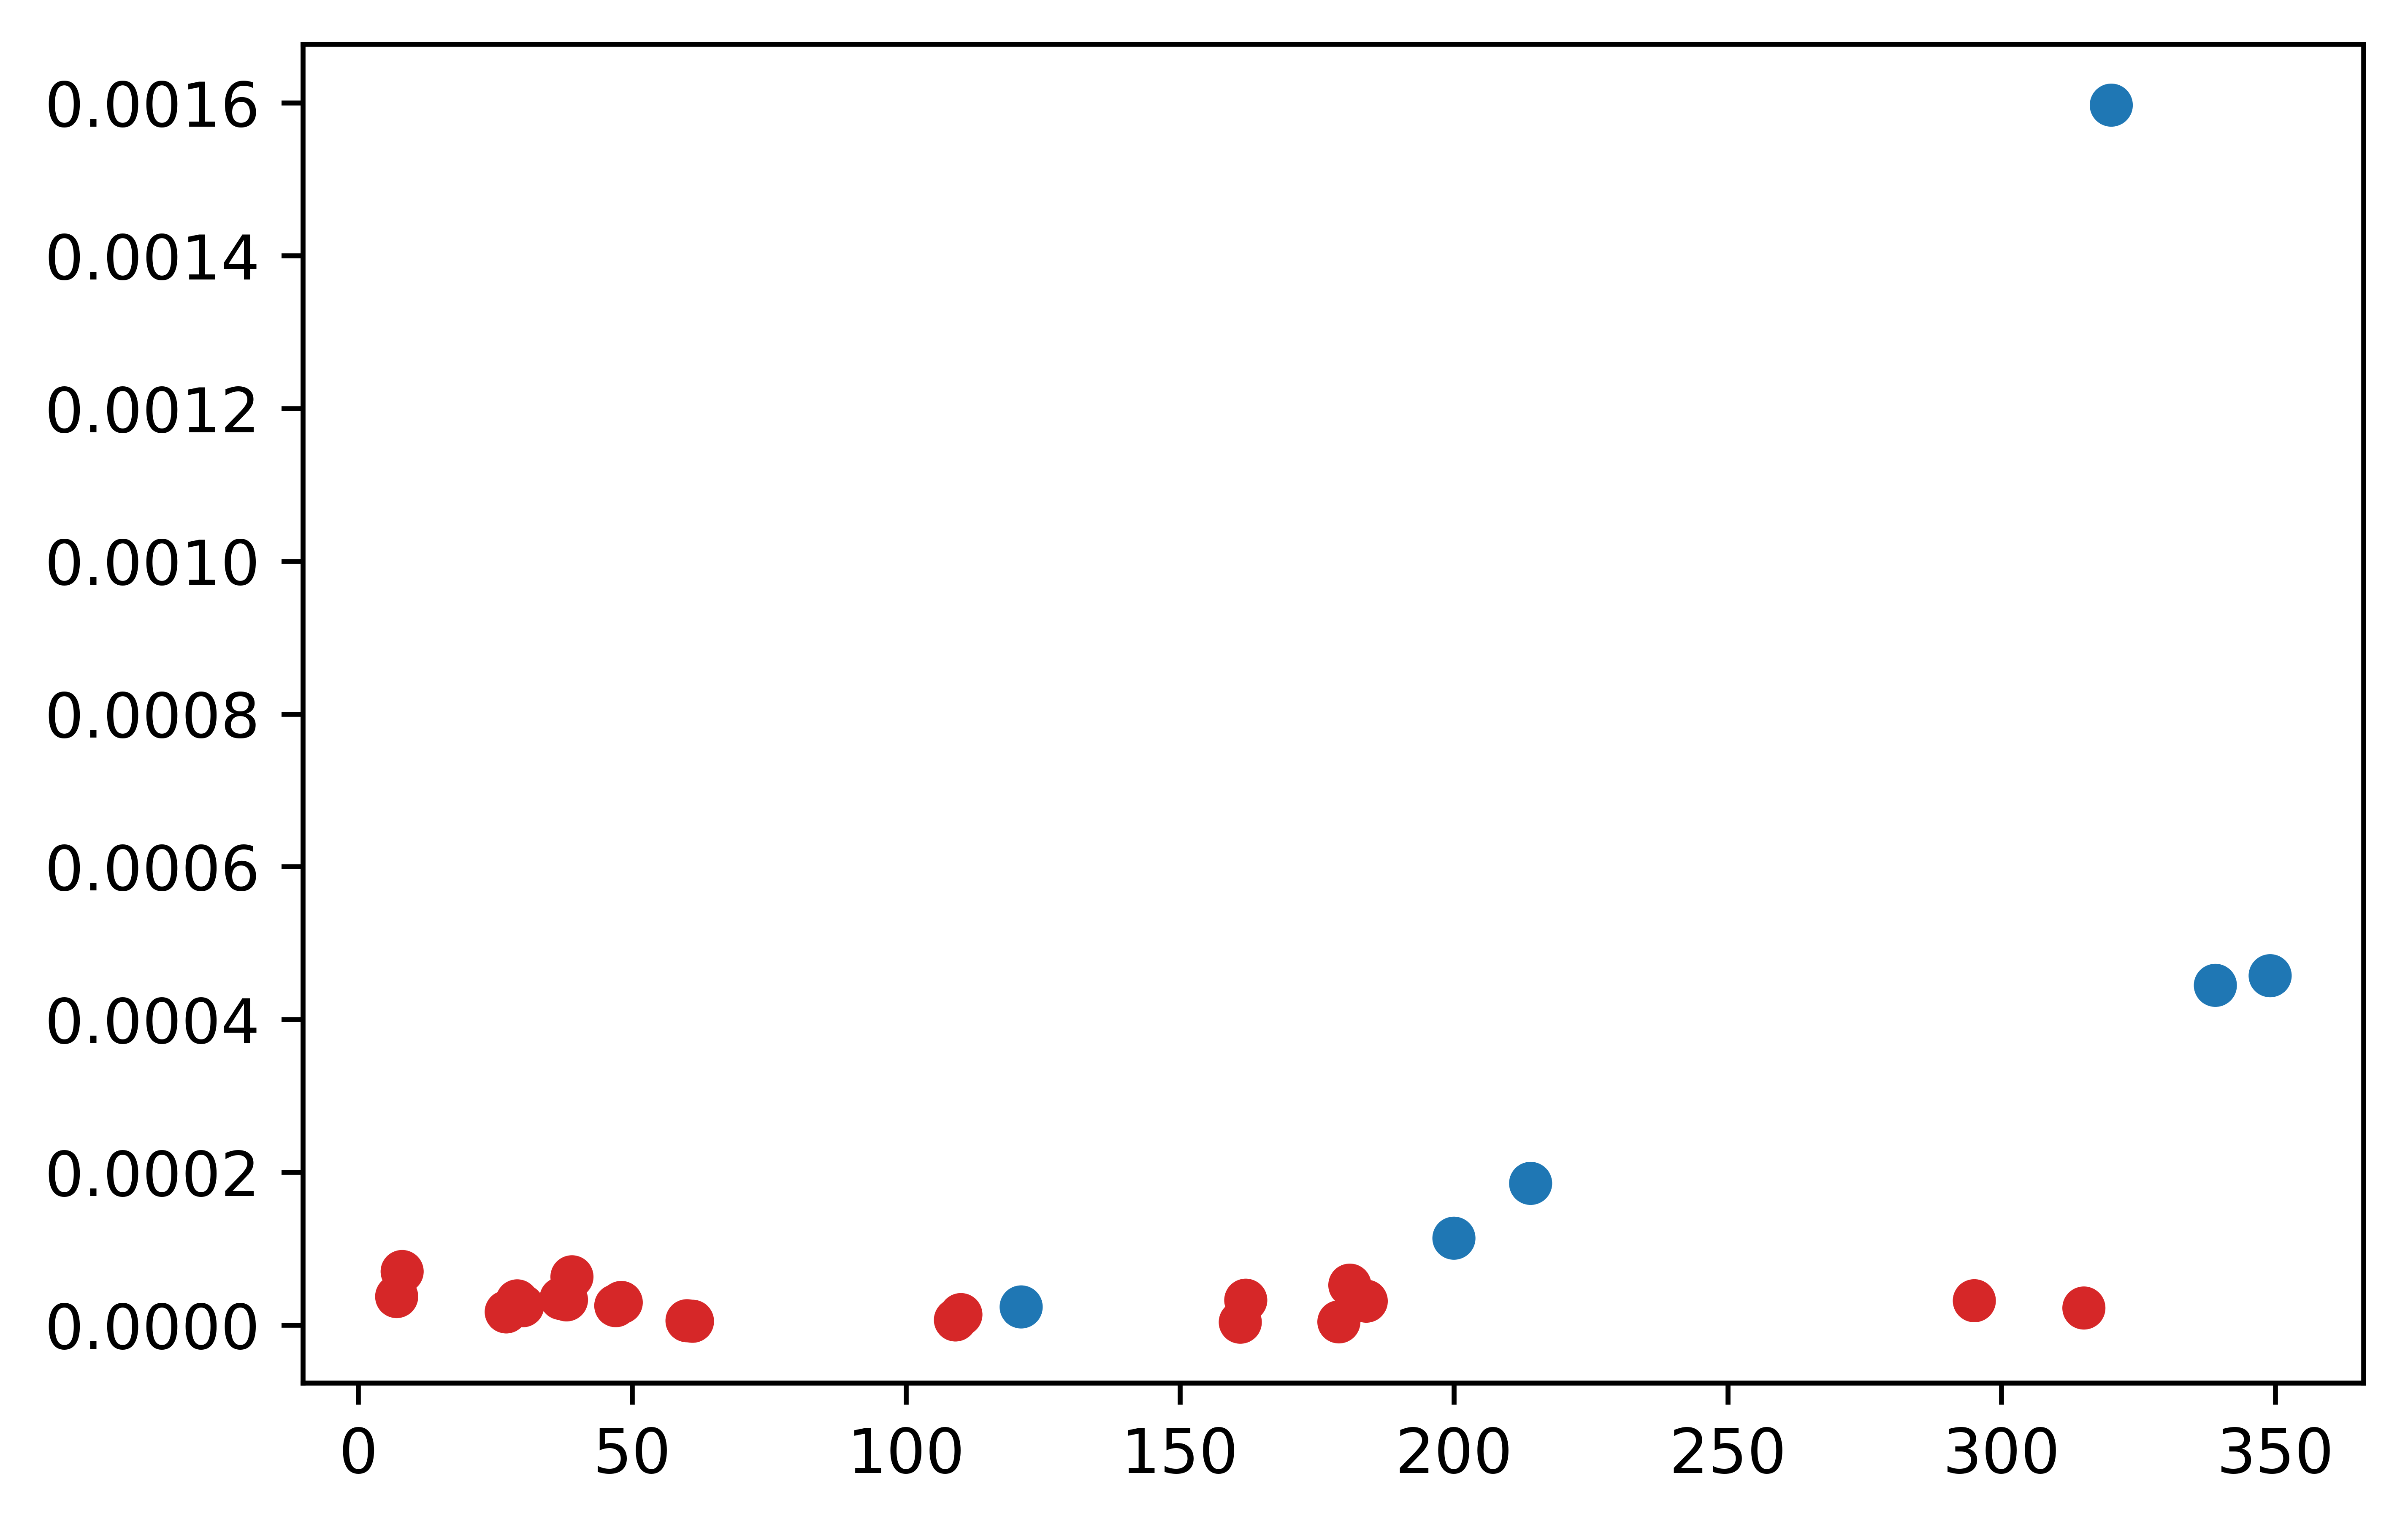

In [10]:
sortNBTWCcir = sorted(NBTWC, reverse=True) # sort nodes in decreasing centrality

# network is now directed, 
# D doesn't change, reciprocal out-degrees are the same
S = np.copy(A)
A2 = np.copy(A)
A2[int(start), int(finish)] = 1 
t = percentage / NBTW_spec_rad(A2, D, S)

NBTW_short = NBTW(t, A2, D, S, normed=True)
sortNBTW_short = sorted(NBTW_short, reverse=True)

# plot differences in ordered nodes
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
difference2 = [NBTW_short[i]-NBTWC[i] for i in range(N)]
ax.axhline(y=0, color='k', lw=1)
plt.plot(difference2)
ax.grid(True)
plt.ylabel('Difference in centrality')
plt.xlabel('Node index')
plt.savefig('circleCentrality{},{}-{}.pdf'.format(percentage*100, start, finish), bbox_inches = "tight")
plt.show()

print('nodes in the network that significantly change centrality:')
count = 0
for i in difference2:
    if i > 0.00015:
        print(count)
    count +=1

# plot differences in circle line
difference3 = []
for i in circle_nodes:
    difference3.append(NBTW_short[i]-NBTWC[i])

colorlist = []
for i in difference3:
    if i>0:
        colorlist.append('tab:blue')
    else:
        colorlist.append('tab:red')
    
plotlist = [abs(i) for i in difference3]
plt.scatter(circle_nodes, plotlist, c=colorlist)
plt.show()

In [11]:
dictionary = dict(zip(circle_nodes, difference3))
# print(dictionary)
# print(len(circle_nodes))

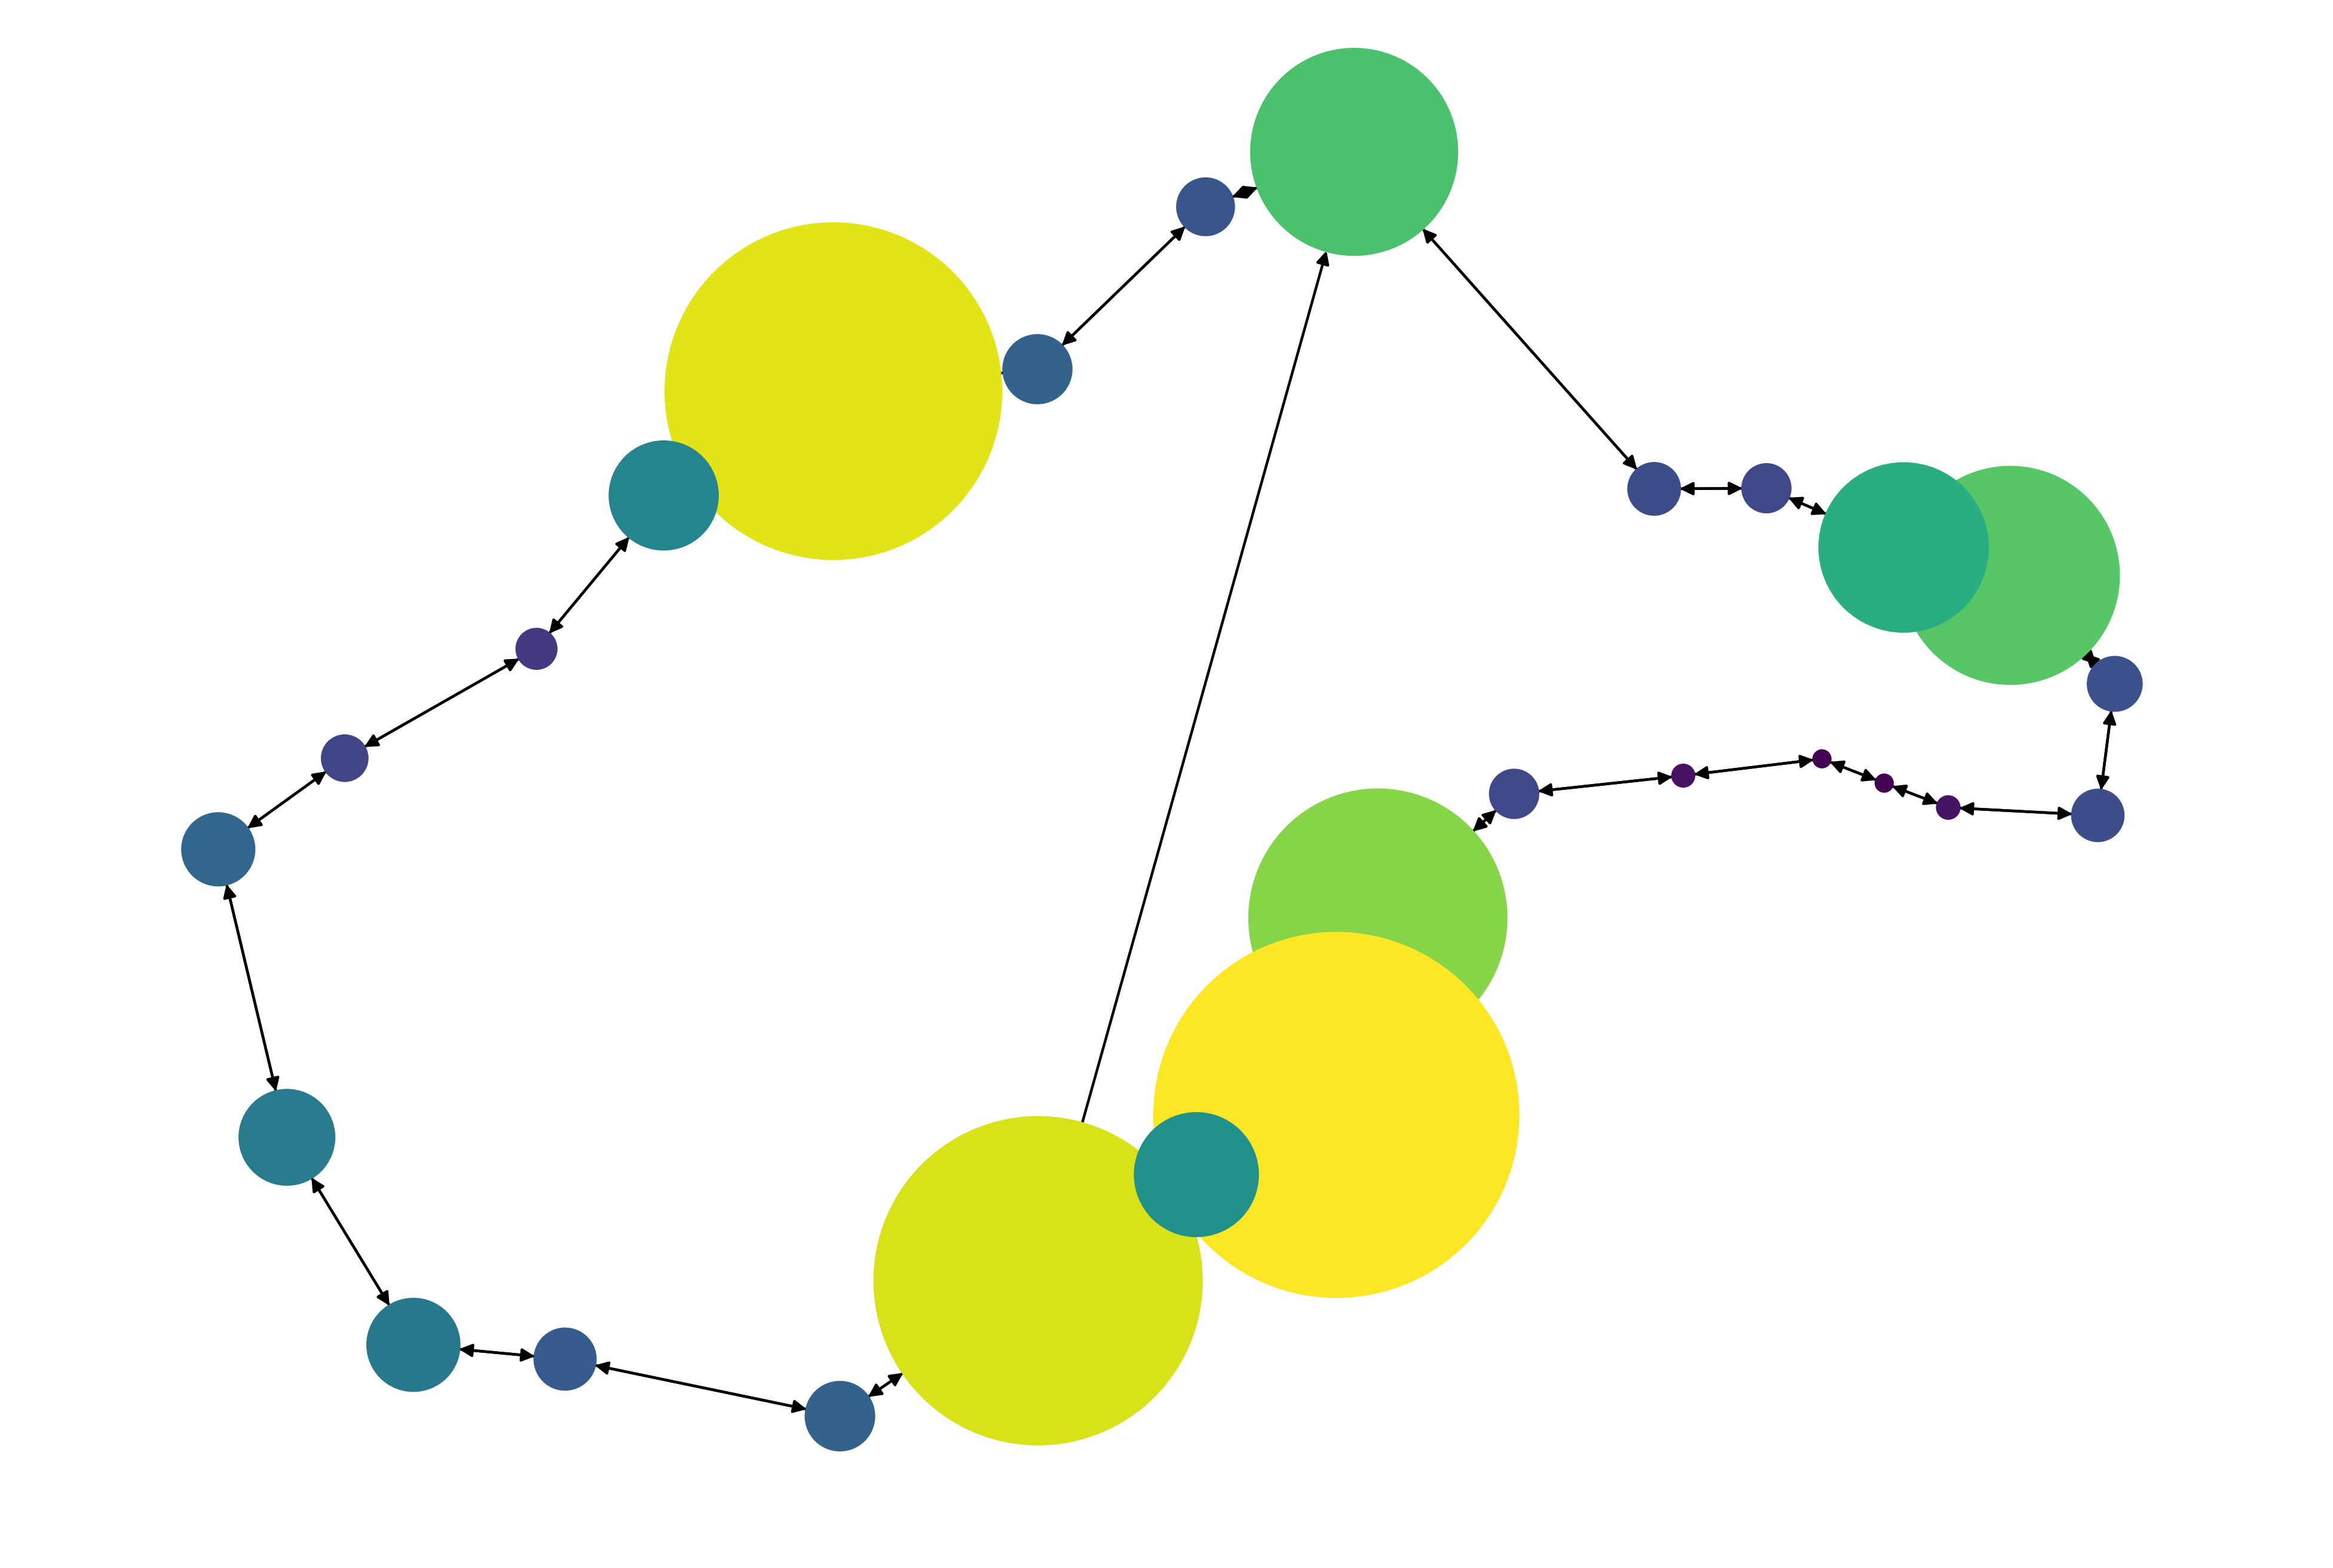

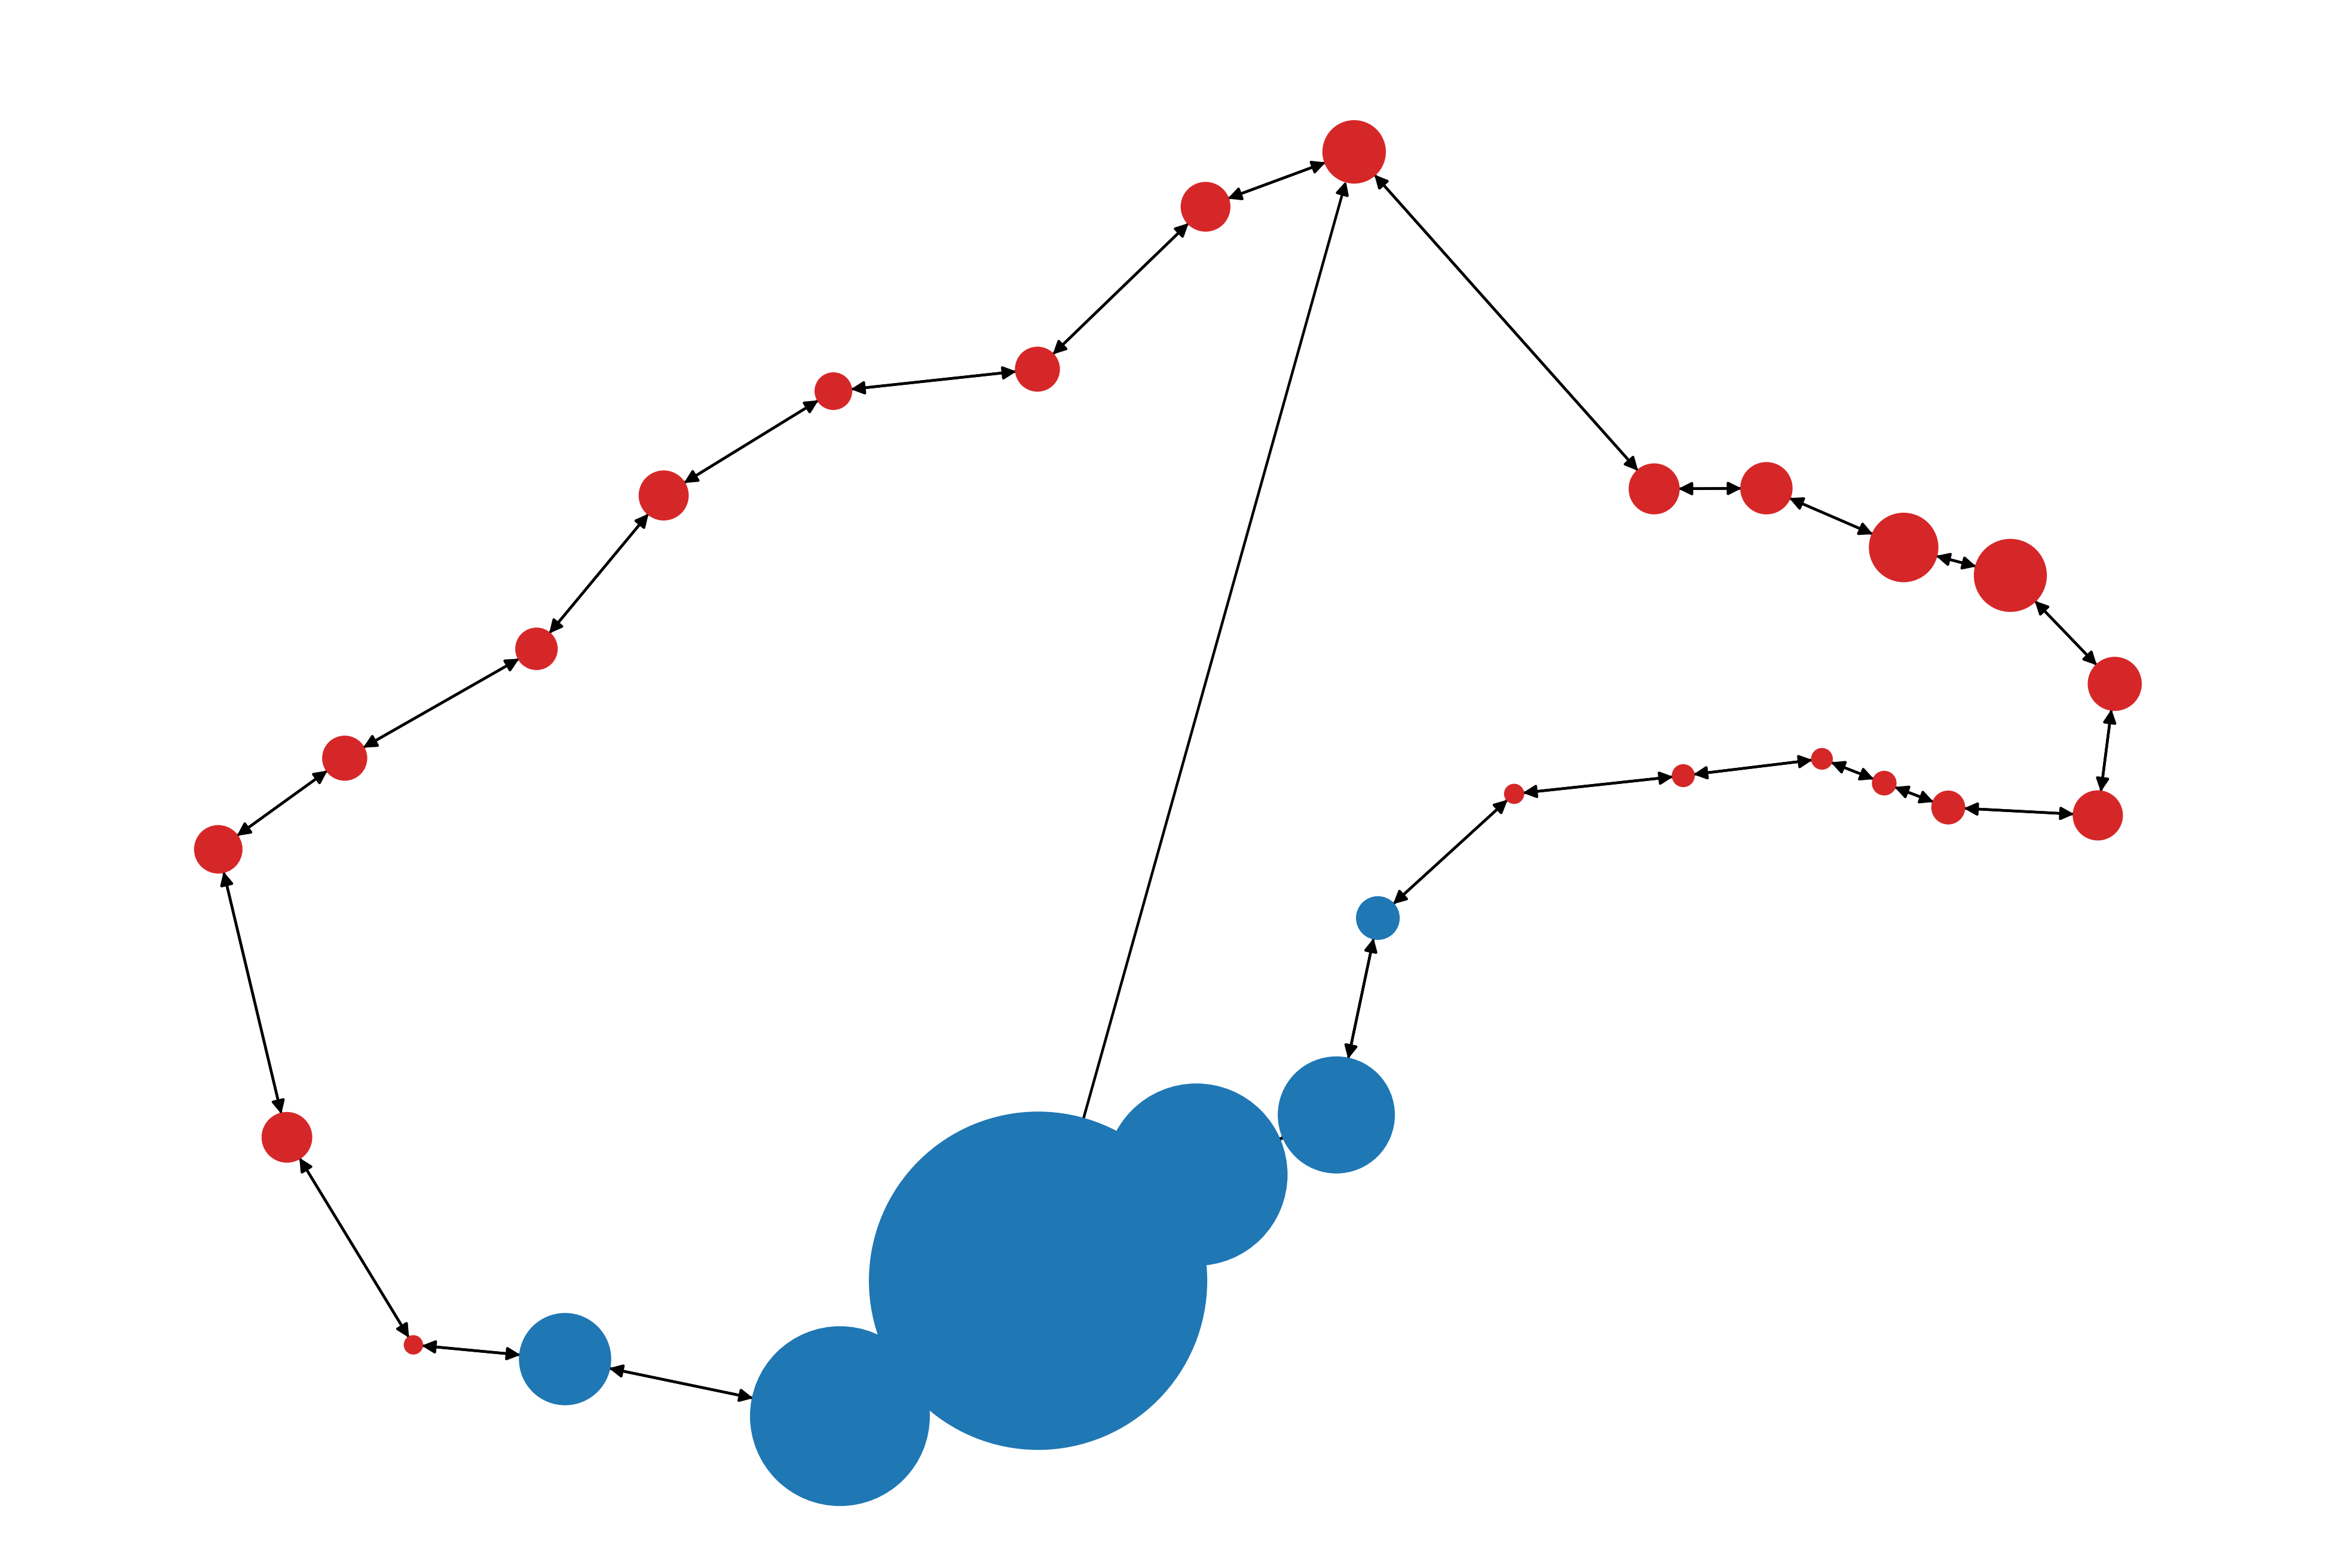

In [12]:
circle_NBTW2 = NBTW_short[circle_nodes]

plt.figure(figsize=(12,8), dpi=320)
nx.draw(Gs, 
        pos=pos_circle, 
        node_color=circle_NBTW2, 
        node_size=(circle_NBTW2*1000)**5, 
#         with_labels=True,
        nodelist=circle_nodes)
# plt.title('Circle line shortcut NBTW centrality with {} percent of the spectrum'.format(percentage*100))
plt.savefig('circleNBTW{}shortcut{}-{}.pdf'.format(percentage*100, start, finish))
plt.show()

# Plot the difference in centrality that emerges when adding the shortcut
plt.figure(figsize=(12,8), dpi=320)
nx.draw(Gs, 
        pos=pos_circle, 
        node_color=colorlist,
        node_size=np.array(plotlist)*1e7, 
#         with_labels=True,
        cmap=plt.cm.RdBu,
        nodelist=circle_nodes,
#         labels=circle_names
       )
# plt.title('Biggest changes in node centrality when adding the shortcut')
plt.savefig('circleShortcutDifferences{}.pdf'.format(percentage*100))
plt.show()

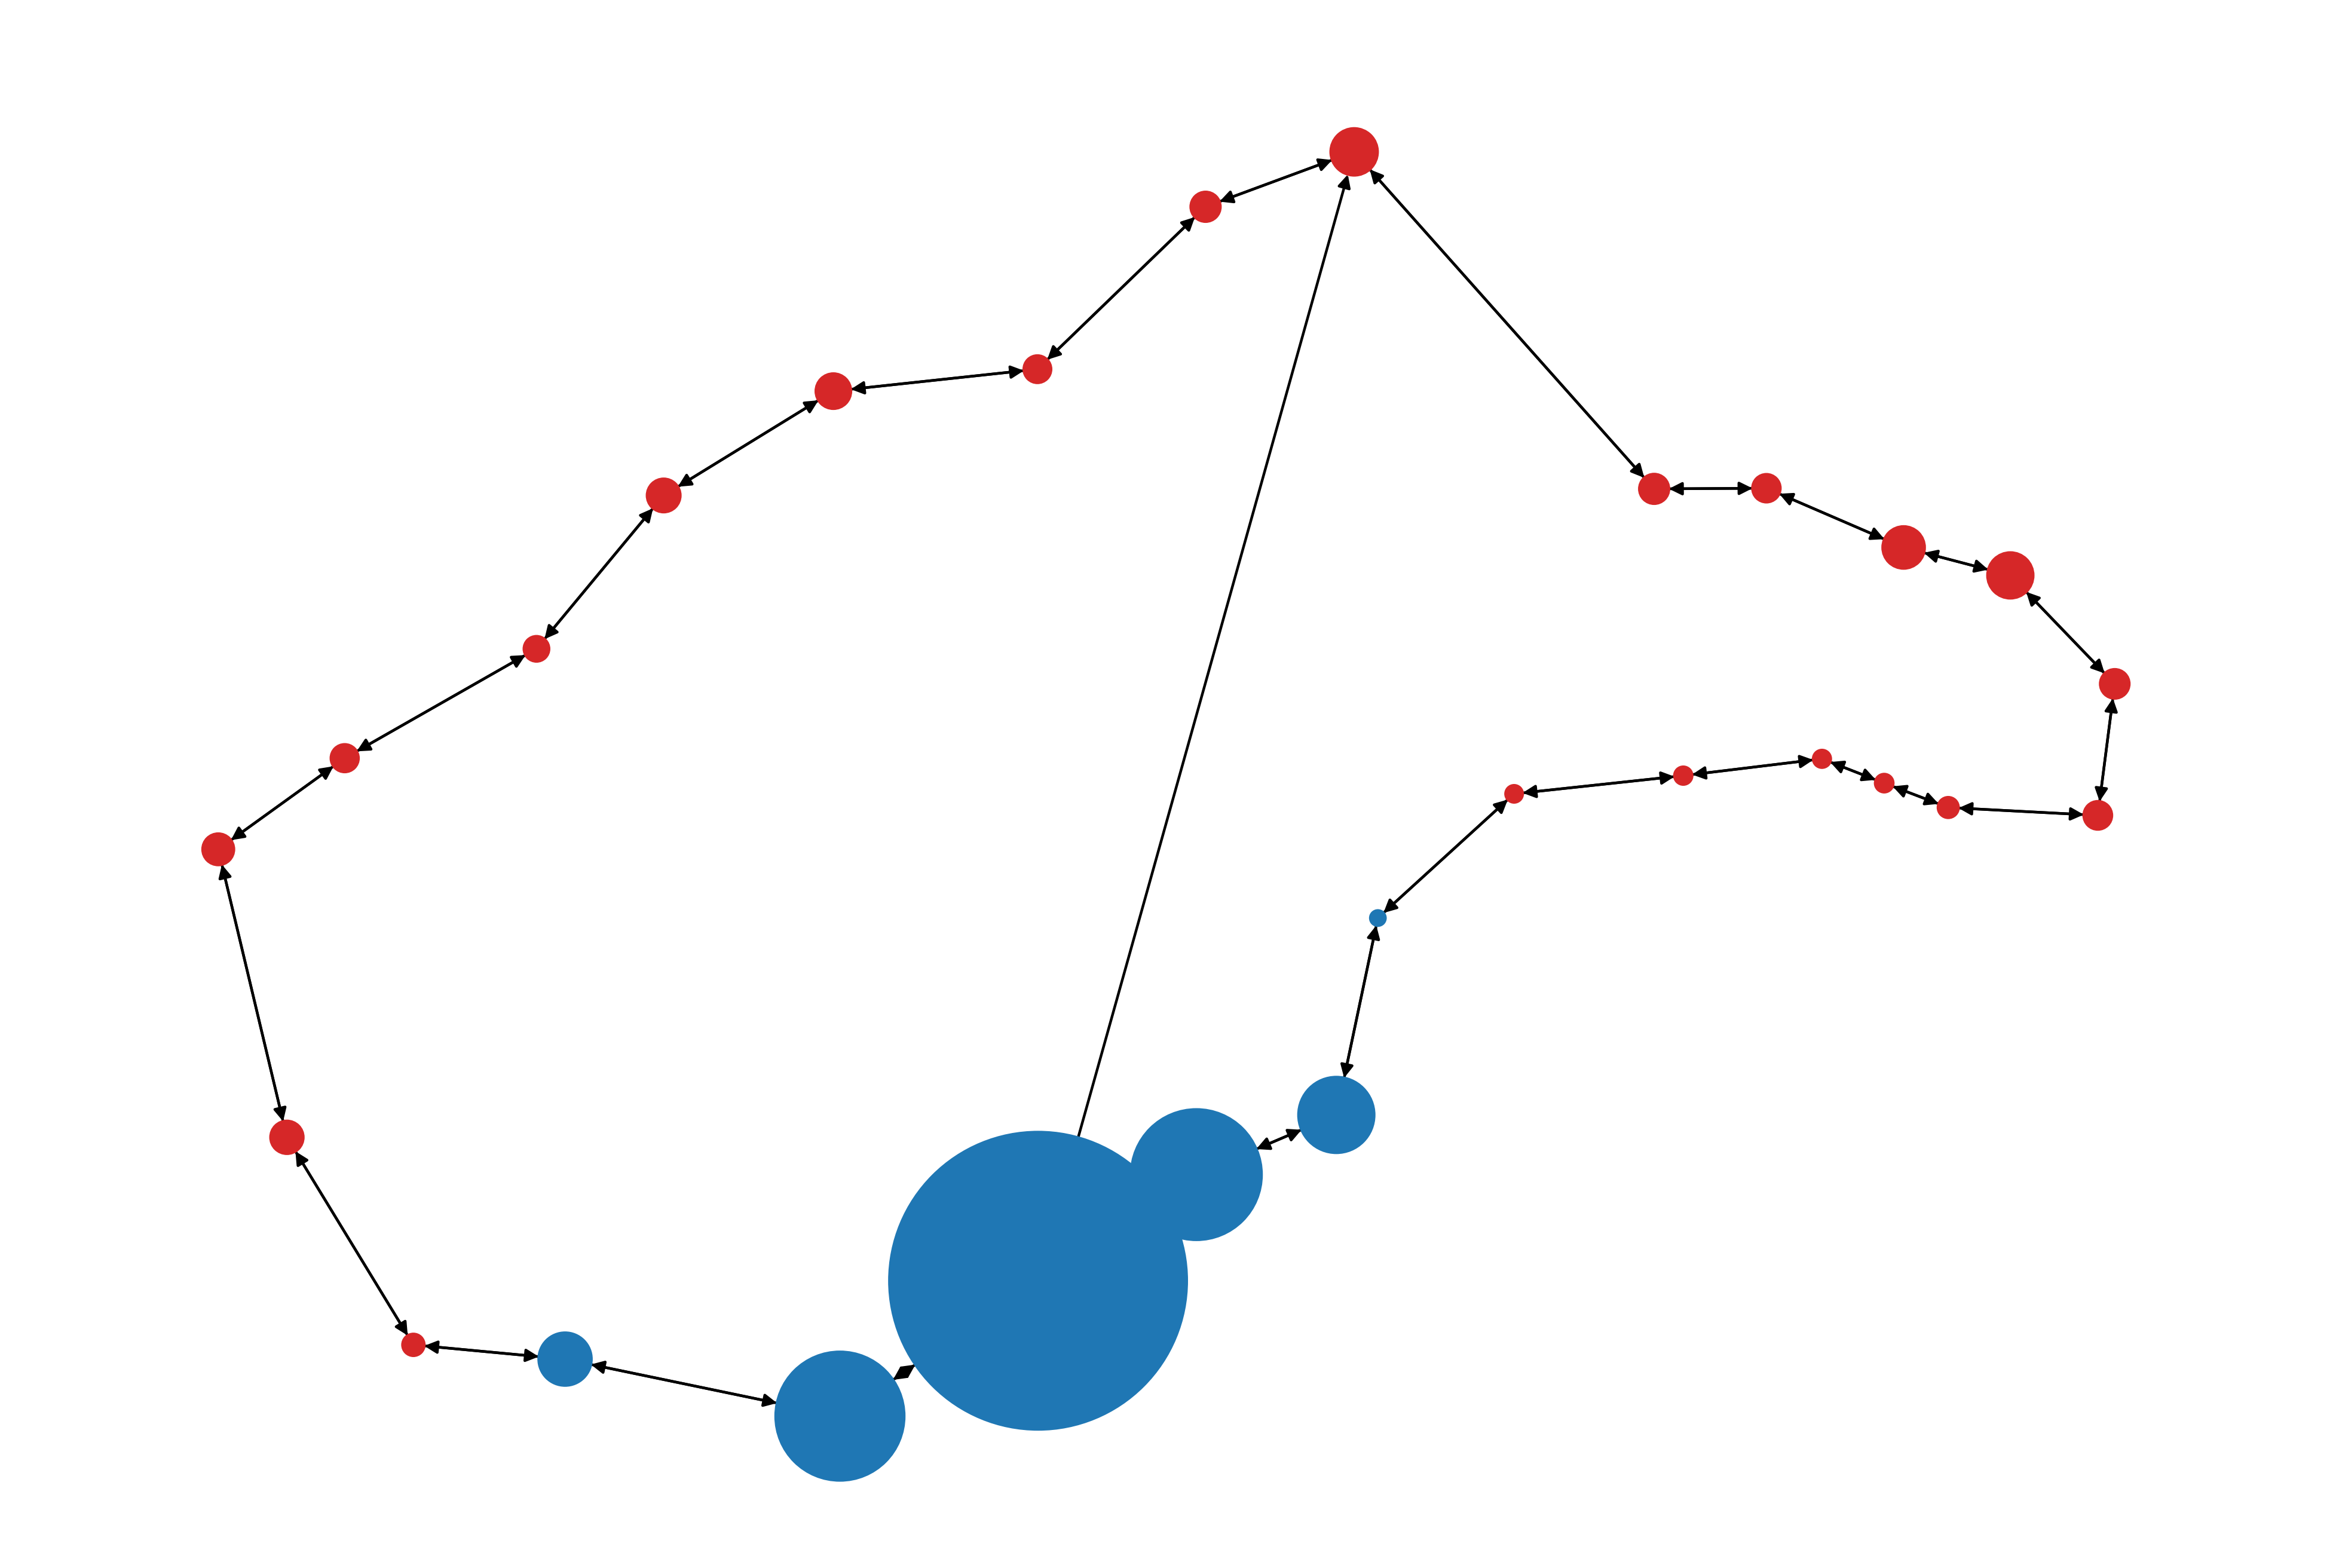

In [13]:
t = percentage / spec_rad(A2)
katz_short = Katz(t, A2, normed=True)


difference3_2 = []
for i in circle_nodes:
    difference3_2.append(katz_short[i]-KatzC[i])

colorlist2 = []
for i in difference3_2:
    if i>0:
        colorlist2.append('tab:blue')
    else:
        colorlist2.append('tab:red')
        
plotlist2  = [abs(i) for i in difference3_2]

# Plot the difference in centrality that emerges when adding the shortcut
plt.figure(figsize=(12,8), dpi=320)
nx.draw(Gs, 
        pos=pos_circle, 
        node_color=colorlist2,
        node_size=np.array(plotlist2)*1e7, 
#         with_labels=True,
        cmap=plt.cm.RdBu,
        nodelist=circle_nodes,
#         labels=circle_names
       )
# plt.title('KATZ Biggest changes in node centrality when adding the shortcut')
plt.savefig('KatzCircleShortcutDifferences{}.pdf'.format(percentage*100))
plt.show()